In [1]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm

import pandas as pd

# Pytorch
import torch
torch.manual_seed(29)
from torch import nn
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
import torch.nn.parallel
cudnn.benchmark = True
import torchvision.transforms as transforms

from twrap.utils import model_summary, tensor_to_torch_var
from utils.models import *
from torch.utils.data import DataLoader
from utils.datasets import dataset, test_dataset_visob, TestSampler, test_dataset
from twrap.transform import ToZNorm

from twrap.utils import genROC

from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 12})

from glob import glob
from sklearn.metrics import roc_curve

from utils.model_utils import genRegionMask


transform=transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize(180),
    transforms.CenterCrop(160),
#     ToZNorm()
    transforms.ToTensor()
    ])


weights_dir = '/media/narsi/LargeData/SP2019/ocularnetv2.1/EX01/weights'

scores_list = [['device', 'visit', 'light_enroll', 'light_verify', 'eye', 'AUC', 'D-prime', 'EER', 'GMR@0.01FMR', 'GMR@0.001FMR']]


In [2]:
model = MODEL4(400, classify = False, attention = True, illum_inv=True)
check_point_file = '/media/narsi/LargeData/SP2019/ocularnetv2.1/EX01/weights/MODEL4_NCA_EXP02/model_best.pth.tar'
checkpoint = torch.load(check_point_file, map_location=lambda storage, loc: storage)
model.load_state_dict(checkpoint['state_dict'])

# check_point_file = '/home/narsi/Desktop/MODEL4_MITG_EXP01/model_best.pth.tar'
model.regions = genRegionMask(w = 20, s1 = 13, s2 = 7, s3 = 7, s4 = 2)
model.regions.data.requires_grad = False
model.cuda()
model.eval()
print('.')

.


In [3]:
device = 'IPHONE'
visit1 = 'EC_VISIT_1'
visit2 = 'EC_VISIT_1'
light_enroll = 'office'
light_verify = 'dark'
eye = 'l'

In [4]:
src_fldr1 = '/media/narsi/fast_drive/CCRops/visob/imgs/'+visit1+'/'+device+'/'+light_enroll
src_fldr2 = '/media/narsi/fast_drive/CCRops/visob/imgs/'+visit2+'/'+device+'/'+light_verify

e_imgs = glob(src_fldr1 + os.sep + 'S1' + os.sep + '*_'+eye+'_*.png')
v_imgs = glob(src_fldr2 + os.sep + 'S2' + os.sep + '*_'+eye+'_*.png')

e_dataset = test_dataset_visob(e_imgs, transform)
v_dataset = test_dataset_visob(v_imgs, transform)

dataset_loader = DataLoader(e_dataset, num_workers=8, pin_memory=True, batch_sampler = TestSampler(len(e_dataset), 128))
e_feat = []
e_labels = []

for (batch_data, batch_target) in tqdm(dataset_loader):

    input_var = tensor_to_torch_var(batch_data, True)
    e_feat.append(model(input_var).data.cpu())
    e_labels += batch_target
    del input_var

e_feat = torch.cat(e_feat, dim = 0)
e_labels = np.asarray(e_labels, dtype = np.object)

dataset_loader = DataLoader(v_dataset, num_workers=8, pin_memory=True, batch_sampler = TestSampler(len(v_dataset), 128))
v_feat = []
v_labels = []

for (batch_data, batch_target) in tqdm(dataset_loader):

    input_var = tensor_to_torch_var(batch_data, True)
    v_feat.append(model(input_var).data.cpu())
    v_labels += batch_target
    del input_var

v_feat = torch.cat(v_feat, dim = 0)
v_labels = np.asarray(v_labels, dtype = np.object)


e_feat = e_feat.cuda()

100%|██████████| 8/8 [00:02<00:00,  2.09it/s]


In [5]:
cmc_50 = np.zeros(shape=(150, ), dtype=np.float64)
count = 0
scores = []
targets = []
for i in tqdm(range(v_feat.shape[0])):
    # i = 1
    v_f = v_feat[i:i+1, ...].cuda()
    v_l = v_labels[i]

    s = F.cosine_similarity(e_feat, v_f).data.cpu().numpy()
#     s = (e_feat * v_f).sum(1).data.cpu().numpy()
#     s = np.median(s, axis = -1)
#     s = torch.sum(torch.abs(e_feat - v_f), dim=1).data.cpu().numpy()
    # s = torch.sum((e_feat != v_f).float(), dim=1).data.cpu().numpy()
    t = 1 * (e_labels == v_l)
    scores.append(s)
    targets.append(t)
    if np.sum(t) != 0:
        locs = np.argsort(-1 * s)
        t_50 = t[locs[:150]]
        t_50 = np.cumsum(t_50)
        t_50[t_50 >= 1] = 1
        cmc_50 += t_50
        count+=1

scores = np.concatenate(scores)
targets = np.concatenate(targets)

100%|██████████| 1022/1022 [00:00<00:00, 2003.83it/s]


In [6]:
def dprime(targets, scores):
    
    Zt = scores[targets==1]
    Ztm = np.mean(Zt)
    Ztv = np.var(Zt)
    
    Zn = scores[targets==0]
    Znm = np.mean(Zn)
    Znv = np.var(Zn)
    
    d_1 = np.abs(Znm - Ztm)
    d_2 = (0.5 * (Ztv + Znv))**0.5
    
    return d_1/d_2

In [7]:
dprime(targets, scores)

2.416209040141337

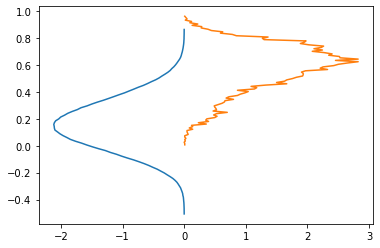

In [8]:
x = plt.hist(scores[targets == 0], bins = 100, density=True)
y = plt.hist(scores[targets == 1], bins = 100, density=True)
plt.close()

plt.plot(-1 * x[0], x[1][1:])
plt.plot(y[0], y[1][1:])

Text(0.5, 1.0, 'GMR @ 0.001 FMR 23.91%')

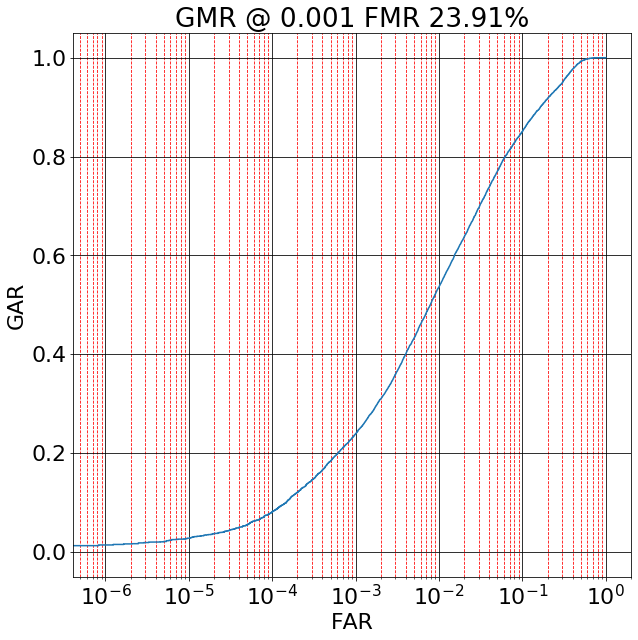

In [9]:
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(10, 10))
plt.plot(np.arange(1, 151), cmc_50/count)
plt.xlim([1, 150])
plt.ylim([0.50, 1.00])
plt.xlabel('Rank-K')
plt.ylabel('Acc')
plt.grid(b=True, which='major', color='k', linestyle='-')
plt.title('RANK - 1: ' + '{0:0.2f}'.format(cmc_50[0] * 100/count) + '% RANK - 10: ' + '{0:0.2f}'.format(cmc_50[9] * 100/count) + ' %')
        
plt.figure(figsize=(10, 10))
far, tar, _ = roc_curve(targets, scores)
plt.semilogx(far, tar)
plt.xlabel('FAR')
plt.ylabel('GAR')
plt.grid(b=True, which='major', color='k', linestyle='-')
plt.grid(b=True, which='minor', color='r', linestyle='--')
plt.title('GMR @ 0.001 FMR ' + '{0:0.2f}'.format(np.min(tar[far>= 0.001] * 100)) + '%')

Text(0.5, 1.0, 'GMR @ 0.001 FMR 29.98%')

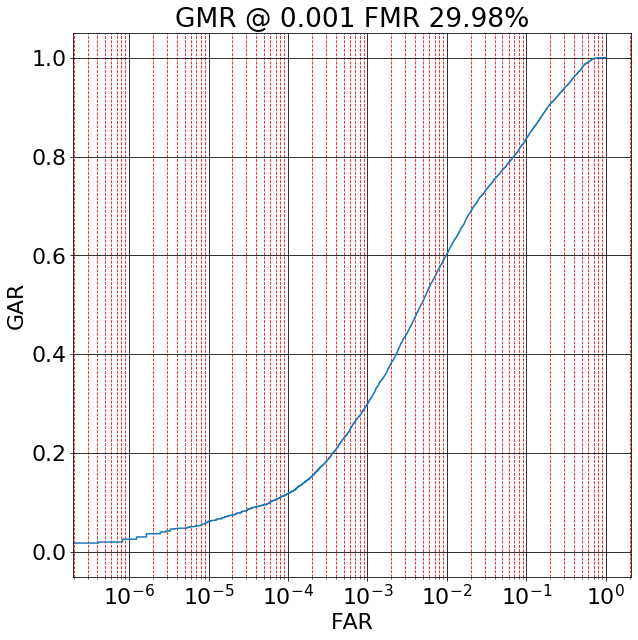

In [8]:
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(10, 10))
plt.plot(np.arange(1, 151), cmc_50/count)
plt.xlim([1, 150])
plt.xlabel('Rank-K')
plt.ylabel('Acc')
plt.grid(b=True, which='major', color='k', linestyle='-')
plt.title('RANK - 1: ' + '{0:0.2f}'.format(cmc_50[0] * 100/count) + '% RANK - 10: ' + '{0:0.2f}'.format(cmc_50[9] * 100/count) + ' %')
        
plt.figure(figsize=(10, 10))
far, tar, _ = roc_curve(targets, scores)
plt.semilogx(far, tar)
plt.xlabel('FAR')
plt.ylabel('GAR')
plt.grid(b=True, which='major', color='k', linestyle='-')
plt.grid(b=True, which='minor', color='r', linestyle='--')
plt.title('GMR @ 0.001 FMR ' + '{0:0.2f}'.format(np.min(tar[far>= 0.001] * 100)) + '%')